In [1]:
import os
import csv
import math
import scipy
import torch
import logging
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from sentence_transformers import SentenceTransformer, LoggingHandler, losses, util, InputExample


d:\nlp\torchenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

device=""
if torch.cuda.is_available():
    device = torch.device("cuda")
    logging.info(f'Using GPU: {torch.cuda.get_device_name()}')
    print(f'Using GPU: {torch.cuda.get_device_name()}')
else:
    device = torch.device("cpu")
    logging.info('Using CPU')
    print('Using CPU')


Using GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [3]:

PATH="data/Task1/"


In [4]:
torch.manual_seed(80085)

In [5]:
model_name = "sentence-transformers/all-MiniLM-L6-v2"
train_batch_size = 8
max_seq_length = 128
num_epochs = 4

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = SentenceTransformer(model_name)
model.to(device)

text1="The cat is on the mat."
text2="The cat is on the carpet."
print(tokenizer(text1, text2, truncation=True, padding='max_length', max_length=128))

{'input_ids': [101, 1996, 4937, 2003, 2006, 1996, 13523, 1012, 102, 1996, 4937, 2003, 2006, 1996, 10135, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [6]:

class TSDataset(Dataset):
    def __init__(self, file_path):
        data = []
        with open(file_path, encoding="utf8") as f:
            reader = csv.DictReader(f, delimiter="\t")
            for row in reader:
                data.append({"sentence1": row["sentence1"], "sentence2": row["sentence2"], "score": float(row["score"])/5})
                # data.append(InputExample(texts=[row["sentence1"], row["sentence2"]], label=float(row["score"])/5))

        self.samples = data

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        return sample


In [7]:
train_dataset = TSDataset(f"{PATH}train.csv")
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)
for x in train_dataloader:
    print(len(x))
    print(len(x["sentence1"]))
    print(len(x["sentence2"]))
    print(len(x["score"]))
    InputExample(texts=[x["sentence1"], x["sentence2"]], label=x["score"])
    break


3
8
8
8


In [8]:
dev_dataset = TSDataset(f"{PATH}dev.csv")
val_dataloader = DataLoader(dev_dataset, shuffle=True, batch_size=train_batch_size)

In [9]:
model_save_path = (
    "output/training-" + model_name 
)
loss_fn = losses.CosineSimilarityLoss(model=model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0025)


In [10]:
model_save_path

'output/training-sentence-transformers/all-MiniLM-L6-v2'

In [11]:
cos_score_transformation=torch.nn.Identity()
loss_fct=torch.nn.MSELoss()

In [12]:
epochs = 6
train_losses = []
val_losses = []

for epoch in range(epochs):
    # Train
    model.train()
    epoch_train_losses = []
    with tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch') as tqdm_loader:
        for batch in tqdm_loader:
            text1=batch["sentence1"]
            text2=batch["sentence2"]
            labels=batch["score"].to(device)
            labels=labels.float()
            # encode_sentence_set_1 = model.encode(text1)
            # encode_sentence_set_2 = model.encode(text2)
            encoded_text1 = tokenizer(text1, padding=True, truncation=True, return_tensors='pt')
            encoded_text2 = tokenizer(text2, padding=True, truncation=True, return_tensors='pt')
            encoded_text1 = {k: v.to(device) for k, v in encoded_text1.items()}
            encoded_text2 = {k: v.to(device) for k, v in encoded_text2.items()}

            sentence_features = [
                {"input_ids": encoded_text1["input_ids"], "attention_mask": encoded_text1["attention_mask"]},
                {"input_ids": encoded_text2["input_ids"], "attention_mask": encoded_text2["attention_mask"]}
            ]
            sentence_features_float = [{k: v.float() for k, v in sf.items()} for sf in sentence_features]
            labels_float = labels.float()
            
            optimizer.zero_grad()
            embeddings=[model(sentence_feature)["sentence_embedding"] for sentence_feature in sentence_features]
            output = cos_score_transformation(torch.cosine_similarity(embeddings[0], embeddings[1]))
            

            loss=loss_fct(output, labels)
            # loss = loss_fn(sentence_features, labels)
            loss = loss.float()


            

            loss.backward()
            optimizer.step()
            epoch_train_losses.append(loss.item())
    train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    train_losses.append(train_loss)

    # Evaluate
    model.eval()
    epoch_val_losses = []
    with tqdm(val_dataloader, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch') as tqdm_loader:
        for batch in tqdm_loader:
            with torch.no_grad():
                text1=batch["sentence1"]
                text2=batch["sentence2"]
                labels=batch["score"].to(device)
                labels=labels.float()
                # encode_sentence_set_1 = model.encode(text1)
                # encode_sentence_set_2 = model.encode(text2)
                encoded_text1 = tokenizer(text1, padding=True, truncation=True, return_tensors='pt')
                encoded_text2 = tokenizer(text2, padding=True, truncation=True, return_tensors='pt')
                encoded_text1 = {k: v.to(device) for k, v in encoded_text1.items()}
                encoded_text2 = {k: v.to(device) for k, v in encoded_text2.items()}

                sentence_features = [
                    {"input_ids": encoded_text1["input_ids"], "attention_mask": encoded_text1["attention_mask"]},
                    {"input_ids": encoded_text2["input_ids"], "attention_mask": encoded_text2["attention_mask"]}
                ]
                sentence_features_float = [{k: v.float() for k, v in sf.items()} for sf in sentence_features]
                labels_float = labels.float()

                embeddings=[model(sentence_feature)["sentence_embedding"] for sentence_feature in sentence_features]
                output = cos_score_transformation(torch.cosine_similarity(embeddings[0], embeddings[1]))
                
                loss=loss_fct(output, labels)
                # loss = loss_fn(sentence_features, labels)
                loss = loss.float()

                epoch_val_losses.append(loss.item())
    
    val_loss = sum(epoch_val_losses) / len(epoch_val_losses)
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}")

    torch.save(model.state_dict(), model_save_path + f"-{epoch + 1}.pth")

        


Epoch 1/6:   0%|          | 0/714 [00:00<?, ?batch/s]

Epoch 1/6: 100%|██████████| 184/184 [00:04<00:00, 40.31batch/s]


Epoch 1/6, Train Loss: 0.14352668248148276, Val Loss: 0.37222953796710656


Epoch 2/6: 100%|██████████| 184/184 [00:04<00:00, 37.80batch/s]


Epoch 2/6, Train Loss: 0.08937236397587159, Val Loss: 0.37225319307459437


Epoch 3/6: 100%|██████████| 184/184 [00:04<00:00, 40.31batch/s]


Epoch 3/6, Train Loss: 0.08809389914216406, Val Loss: 0.37280079228398594


Epoch 4/6: 100%|██████████| 184/184 [00:04<00:00, 37.53batch/s]


Epoch 4/6, Train Loss: 0.08876041369773552, Val Loss: 0.3721577966504771


Epoch 5/6: 100%|██████████| 184/184 [00:05<00:00, 36.00batch/s]


Epoch 5/6, Train Loss: 0.0874291716667847, Val Loss: 0.37215237594816997


Epoch 6/6: 100%|██████████| 184/184 [00:04<00:00, 37.74batch/s]


Epoch 6/6, Train Loss: 0.08826777924253952, Val Loss: 0.37245200647284155


In [13]:
torch.save(model.state_dict(), model_save_path + "-final.pth")

In [14]:
train_losses, val_losses

([0.14352668248148276,
  0.08937236397587159,
  0.08809389914216406,
  0.08876041369773552,
  0.0874291716667847,
  0.08826777924253952],
 [0.37222953796710656,
  0.37225319307459437,
  0.37280079228398594,
  0.3721577966504771,
  0.37215237594816997,
  0.37245200647284155])

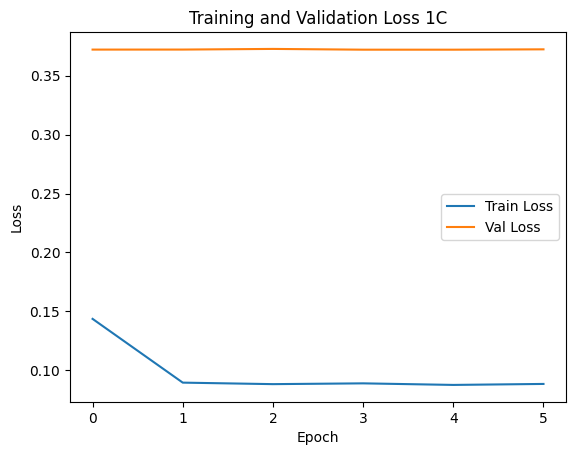

In [15]:


plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss 1C')
plt.legend()
plt.show()